In [2]:
# 導入庫
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask
from dask_ml.model_selection import train_test_split as dask_train_test_split
import joblib
import gc
import os
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt

In [3]:
# 參數設置
IS_RESAMPLE = True
TARGET_RATIO = 60

INIT_MODEL = False

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def dynamic_resample_dask(X_ddf, y_ddf, under_strategy=0.016, over_strategy=0.1):
    if not isinstance(X_ddf, dd.DataFrame) or not isinstance(y_ddf, dd.Series):
        raise ValueError("X_ddf and y_ddf must be Dask DataFrames/Series")
    
    # 計算原始數據的類別分佈
    X_pd = X_ddf.compute()
    y_pd = y_ddf.compute()
    
    # 設置採樣策略
    # over = RandomOverSampler(sampling_strategy=over_strategy, random_state=42)
    under = RandomUnderSampler(sampling_strategy=1/under_strategy, random_state=42)
    
    # 構建管道
    # steps = [('o', over), ('u', under)]
    steps = [('u', under)]
    pipeline = Pipeline(steps=steps)
    
    # 執行重採樣
    X_resampled, y_resampled = pipeline.fit_resample(X_pd, y_pd)
    
    # 轉回 Dask DataFrame
    X_res_ddf = dd.from_pandas(X_resampled, npartitions=X_ddf.npartitions)
    y_res_ddf = dd.from_pandas(y_resampled, npartitions=y_ddf.npartitions)
    
    return X_res_ddf, y_res_ddf
# 結果這方法比較快 f1也會多個0.004

In [4]:
# 資料載入
train_file = './data/training.csv'
val_file = './data/public_x.csv'
# train_file = './data/mini_train.csv'
# val_file = './data/mini_val.csv'

In [5]:
# 選擇使用 Dask 載入（更推薦，因為效率更高）
print("Loading training data with Dask...")
ddf = dd.read_csv(train_file, sample=1048576, blocksize='128MB')
# 檢查特徵重要性檔案是否存在
feature_importance_file = './feature_importance.csv'
if INIT_MODEL == False and os.path.exists(feature_importance_file):
    print(f"檢測到 {feature_importance_file}，直接讀取特徵重要性...")

    # 精煉特徵
    feature_importance_df = pd.read_csv(feature_importance_file)
    important_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].tolist()
    print(f"保留的特徵數量: {len(important_features)}")
    print("保留的特徵:", important_features)

    X_ddf = ddf[important_features]
    del feature_importance_df
    gc.collect()
else:
    X_ddf = ddf.drop(columns=['ID', '飆股'])
y_ddf = ddf['飆股']
X_ddf = X_ddf.fillna(X_ddf.mean()).replace([np.inf, -np.inf], np.nan).fillna(X_ddf.max().max())

del ddf
gc.collect()

Loading training data with Dask...


0

In [6]:
# 先分割訓練集和測試集
X_train_ddf, X_test_ddf, y_train_ddf, y_test_ddf = dask_train_test_split(
    X_ddf, y_ddf, test_size=0.1, random_state=42, shuffle=True
)

del X_ddf, y_ddf
gc.collect()

0

In [7]:
# 只對訓練集進行欠採樣
if IS_RESAMPLE == True:
    print("對訓練集進行欠採樣...")
    X_train_ddf, y_train_ddf = dynamic_resample_dask(X_train_ddf, y_train_ddf, TARGET_RATIO)
    # print("採樣後訓練集分佈:", y_train_ddf.value_counts().compute())

對訓練集進行欠採樣...


In [ ]:
import shutil  

# 先清空之前的檔案
#TODO 應該先檢查有無檔案
shutil.rmtree('./X_test_ddf.csv')  
shutil.rmtree('./y_train_ddf.csv')  
shutil.rmtree('./X_train_ddf.csv')  
shutil.rmtree('./y_test_ddf.csv')  

# 匯出到CSV
print("匯出CSV以清空計算圖")
X_test_ddf.to_csv('./X_test_ddf.csv', index=False)
y_train_ddf.to_csv('./y_train_ddf.csv', index=False)
X_train_ddf.to_csv('./X_train_ddf.csv', index=False)
y_test_ddf.to_csv('./y_test_ddf.csv', index=False)
print("所有資料已匯出到 CSV！")

匯出CSV以清空計算圖
所有資料已匯出到 CSV！


In [201]:
# 計算正負樣本權重
# neg_count = y_train_ddf[y_train_ddf == 0].shape[0].compute()
# pos_count = y_train_ddf[y_train_ddf == 1].shape[0].compute()
# scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
# del neg_count, pos_count, 
# gc.collect()
scale_pos_weight = TARGET_RATIO
print(f"正負樣本權重: {scale_pos_weight:.2f}")

正負樣本權重: 60.00


In [202]:
#TODO 採樣完 從這邊開始就好了
# 讀取 CSV
print("轉換訓練集格式為熊貓DF...")
X_train_ddf = dd.read_csv('./X_train_ddf.csv/*', sample=1048576, blocksize='128MB')
y_train_ddf = dd.read_csv('./y_train_ddf.csv/*', sample=1048576, blocksize='128MB')

# 初始化空的 DataFrame
X_train = pd.DataFrame()
y_train = pd.DataFrame()

# 分批合併
batch_size = 10  # 每次處理 10 個分割
for i in range(0, X_train_ddf.npartitions, batch_size):
    print(f"處理批次 {i//batch_size + 1}")
    # 一次計算多個分割
    X_batch = X_train_ddf.partitions[i:min(i + batch_size, X_train_ddf.npartitions)].compute()
    y_batch = y_train_ddf.partitions[i:min(i + batch_size, y_train_ddf.npartitions)].compute()
    # 合併到結果
    X_train = pd.concat([X_train, X_batch], axis=0, ignore_index=True)
    y_train = pd.concat([y_train, y_batch], axis=0, ignore_index=True)
    del X_batch, y_batch
    gc.collect()

轉換訓練集格式為熊貓DF...
處理批次 1
處理批次 2
處理批次 3
處理批次 4
處理批次 5
處理批次 6
處理批次 7
處理批次 8
處理批次 9
處理批次 10


In [203]:
# 讀取 CSV
print("轉換測試集格式為熊貓DF...")
X_test_ddf = dd.read_csv('./X_test_ddf.csv/*', sample=1048576, blocksize='128MB')
y_test_ddf = dd.read_csv('./y_test_ddf.csv/*', sample=1048576, blocksize='128MB')

# 初始化空的 DataFrame
X_test = pd.DataFrame()
y_test = pd.DataFrame()

# 分批合併
batch_size = 10  # 每次處理 10 個分割
for i in range(0, X_test_ddf.npartitions, batch_size):
    print(f"處理批次 {i//batch_size + 1}")
    # 一次計算多個分割
    X_batch = X_test_ddf.partitions[i:min(i + batch_size, X_test_ddf.npartitions)].compute()
    y_batch = y_test_ddf.partitions[i:min(i + batch_size, y_test_ddf.npartitions)].compute()
    # 合併到結果
    X_test = pd.concat([X_test, X_batch], axis=0, ignore_index=True)
    y_test = pd.concat([y_test, y_batch], axis=0, ignore_index=True)
    del X_batch, y_batch
    gc.collect()

轉換測試集格式為熊貓DF...
處理批次 1
處理批次 2
處理批次 3
處理批次 4
處理批次 5
處理批次 6
處理批次 7
處理批次 8
處理批次 9
處理批次 10


c:\Users\faiz1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\faiz1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\faiz1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[328]	train's binary_logloss: 0.00793424	train's auc: 0.999999	test's binary_logloss: 0.0253353	test's auc: 0.981488
模型已儲存至 './lgbm_stock_model_v13.pkl'
特徵重要性已儲存


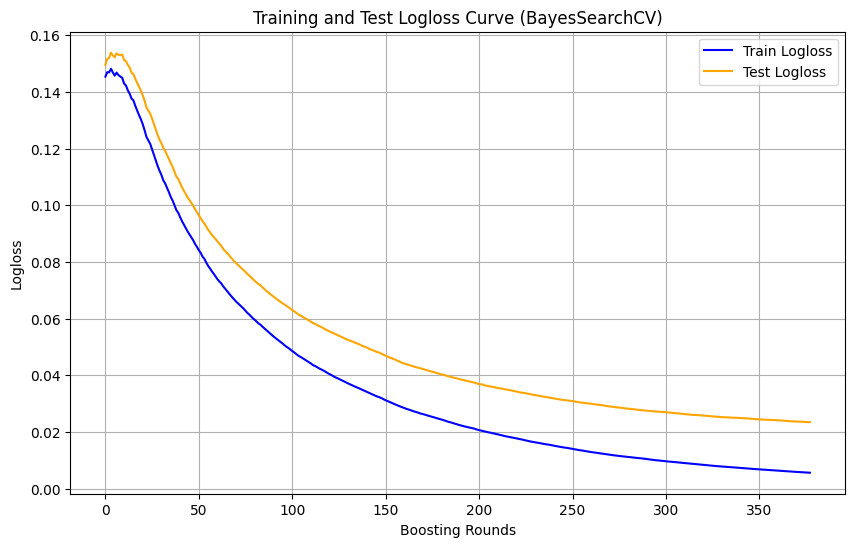

Logloss 曲線已繪製並儲存為 'logloss_curve_v13.png'


In [396]:
# # 定義 LightGBM 模型（固定不搜索的參數）
# from sklearn.model_selection import StratifiedKFold

# #TODO yoyo區 精煉特徵
# feature_importance_df = pd.read_csv('feature_importance.csv')
# important_features = feature_importance_df[feature_importance_df['Importance'] >= 18]['Feature'].tolist()
# print(f"保留的特徵數量: {len(important_features)}")
# print("保留的特徵:", important_features)

# # 過濾訓練和測試數據，僅保留重要性大於 0 的特徵
# X_train = X_train[important_features]
# X_test = X_test[important_features]

# # 計算特徵相關性
# correlation_matrix = X_train.corr(method='pearson')

# # 找出高度相關特徵對（相關性絕對值 > 0.8）
# high_corr = np.where(np.abs(correlation_matrix) > 0.8)
# high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) 
#                    for x, y in zip(*high_corr) if x != y and x < y]
# print("高度相關特徵對:", high_corr_pairs)

# # 根據特徵重要性移除高度相關特徵
# if high_corr_pairs:
#     # 從 feature_importance_df 獲取特徵重要性
#     feature_importance_dict = dict(zip(feature_importance_df['Feature'], feature_importance_df['Importance']))
    
#     # 決定要移除的特徵（保留重要性較高的特徵）
#     features_to_remove = []
#     for feat1, feat2 in high_corr_pairs:
#         # 比較兩個特徵的重要性
#         imp1 = feature_importance_dict.get(feat1, 0)
#         imp2 = feature_importance_dict.get(feat2, 0)
#         # 移除重要性較低的那個特徵
#         if imp1 > imp2:
#             features_to_remove.append(feat2)
#         else:
#             features_to_remove.append(feat1)
    
#     # 移除重複的移除特徵
#     features_to_remove = list(set(features_to_remove))
#     print("將移除的特徵:", features_to_remove)
    
#     # 更新 important_features
#     important_features = [f for f in important_features if f not in features_to_remove]
#     print(f"移除高度相關特徵後保留的特徵數量: {len(important_features)}")
#     print("最終保留的特徵:", important_features)
    
#     # 更新 X_train 和 X_test
#     X_train = X_train[important_features]
#     X_test = X_test[important_features]
# else:
#     print("沒有找到高度相關特徵對，保留所有特徵")

# # 精煉特徵
# feature_importance_df = pd.read_csv('feature_importance.csv')
# important_features = feature_importance_df[feature_importance_df['Importance'] > 20]['Feature'].tolist() # 0.7101
# print(f"保留的特徵數量: {len(important_features)}")
# print("保留的特徵:", important_features)

# # 過濾訓練和測試數據，僅保留重要性大於 0 的特徵
# X_train = X_train[important_features]
# X_test = X_test[important_features]

# model = lgb.LGBMClassifier(
#     scale_pos_weight=scale_pos_weight,
#     learning_rate=0.1,
#     max_depth=8,
#     min_child_samples=155,
#     n_estimators=1000,
#     lambda_l1=0.7,
#     lambda_l2=0.3,
#     feature_fraction=1,
#     bagging_fraction=1,
#     bagging_freq=1,
#     random_state=42,
#     verbose=-1,
#     colsample_bytree=0.9,
#     subsample=0.86,
#     n_jobs=-1
# )

# # 定義參數搜索空間（調整後）
# search_spaces = {
#     # 'learning_rate': Real(0.01, 0.3),      # 擴大範圍，允許更高學習率
#     # 'max_depth': Integer(3, 8),            # 縮小範圍，控制過擬合
#     # 'min_child_samples': Integer(60, 180), # 調整範圍，減少過擬合
#     # 'n_estimators': Integer(150, 250),     # 縮小範圍，根據 Logloss 曲線趨勢
#     # 'lambda_l1': Real(0.1, 1.0),          # 增強正則化
#     # 'lambda_l2': Real(0.1, 1.0),          # 增強正則化
#     'num_leaves': Integer(20, 70),         # 控制葉子數，與 max_depth 配合
#     # 'feature_fraction': Real(0.5, 1.0),    # 特徵抽樣，減少過擬合
#     # 'bagging_fraction': Real(0.5, 1.0),    # 數據抽樣，減少過擬合
#     # 'bagging_freq': Integer(1, 5)          # bagging 頻率
# }

# # 定義評估指標（正類 F1 分數）
# f1_scorer = make_scorer(f1_score, average='binary')

# # 初始化 BayesSearchCV（使用 StratifiedKFold 確保正負類比例一致）
# bayes_search = BayesSearchCV(
#     estimator=model,
#     search_spaces=search_spaces,
#     scoring=f1_scorer,
#     n_iter=40,
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # 只能用測試集交叉驗證 有其侷限性
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
#     return_train_score=True
# )

# # 執行超參數搜索
# bayes_search.fit(X_train, y_train)

# # 獲取最佳參數
# print("最佳參數:", bayes_search.best_params_)
# print("最佳 F1 分數（交叉驗證）:", bayes_search.best_score_)
# print("最佳參數的訓練集 F1 分數:", bayes_search.cv_results_['mean_train_score'][bayes_search.best_index_])

# 用最佳參數創建新模型（加入提前停止）
# https://blog.csdn.net/starmoth/article/details/84586709
# # 20特徵 0.7099模型
# final_model = lgb.LGBMClassifier(
#     scale_pos_weight=scale_pos_weight,
#     learning_rate=0.1, # 特徵越少lr要越大
#     max_depth=8,
#     min_child_samples=130,
#     n_estimators=1000,
#     lambda_l1=0.5,
#     lambda_l2=0.5,
#     num_leaves=31,
#     feature_fraction=1,
#     bagging_fraction=0.95, # 0.6914
#     bagging_freq=2,
#     random_state=42,
#     verbose=-1,
#     colsample_bytree=0.9, # 有改沒改差不多
#     subsample=0.86, # 有改沒改差不多
#     n_jobs=-1,
    
# )
# # 20特徵 0.7099模型
# final_model = lgb.LGBMClassifier(
#     scale_pos_weight=scale_pos_weight,
#     learning_rate=0.1, # 特徵越少lr要越大
#     max_depth=8,
#     min_child_samples=130,
#     n_estimators=1000,
#     lambda_l1=0.5,
#     lambda_l2=0.5,
#     num_leaves=31,
#     feature_fraction=1,
#     bagging_fraction=0.95, # 0.6914
#     bagging_freq=2,
#     random_state=42,
#     verbose=-1,
#     colsample_bytree=0.9, # 有改沒改差不多
#     subsample=0.86, # 有改沒改差不多
#     n_jobs=-1,
    
# )
# https://blog.csdn.net/u012735708/article/details/83749703 2018的文章 param不太一樣了
# https://www.cnblogs.com/TimVerion/p/11436001.html
# https://blog.csdn.net/lizz2276/article/details/121184297

#TODO yoyo模型
final_model = lgb.LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    # is_unbalance=True,
    learning_rate=0.1,
    max_depth=20,
    min_child_samples=300, # 這搭配深度9來到了0.7
    # min_child_samples=bayes_search.best_params_['min_child_samples'],
    n_estimators=550, # 多多學總是好事^ ^
    lambda_l1=0.7,
    lambda_l2=0.3, # 這個組合F1可以到0.7哩
    # num_leaves=bayes_search.best_params_['num_leaves'],
    feature_fraction=1,
    bagging_fraction=1,
    bagging_freq=1,
    random_state=42,
    verbose=-1,
    colsample_bytree=0.9,
    subsample=0.86,
    n_jobs=-1
)

# 訓練新模型（啟用提前停止，記錄 Logloss 曲線）
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric=['binary_logloss', 'auc'],
    eval_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]  # 提前停止：50 輪內無提升則停止
)

# 儲存最終模型
joblib.dump(final_model, './lgbm_stock_model_v13.pkl')
print("模型已儲存至 './lgbm_stock_model_v13.pkl'")

# 特徵重要性
feature_names = X_train.columns.tolist()
importance = final_model.feature_importances_
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
new_feature_importance_file = 'feature_importance.csv' if INIT_MODEL else 'feature_importance_final_model_report.csv'
feature_df.to_csv(new_feature_importance_file, index=False)
print("特徵重要性已儲存")

# 繪製 Logloss 曲線
plt.figure(figsize=(10, 6))
plt.plot(final_model.evals_result_['train']['binary_logloss'], label='Train Logloss', color='blue')
plt.plot(final_model.evals_result_['test']['binary_logloss'], label='Test Logloss', color='orange')
plt.xlabel('Boosting Rounds')
plt.ylabel('Logloss')
plt.title('Training and Test Logloss Curve (BayesSearchCV)')
plt.legend()
plt.grid(True)
plt.savefig('logloss_curve_v13.png')
plt.show()
print("Logloss 曲線已繪製並儲存為 'logloss_curve_v13.png'")

# 清理記憶體 為了方便重新執行，暫時註解
# del X_train, y_train
# gc.collect()

開始預測...
最佳閾值: 0.8102
最佳 F1 分數: 0.6618

最佳分類報告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19876
           1       0.72      0.61      0.66       147

    accuracy                           1.00     20023
   macro avg       0.86      0.81      0.83     20023
weighted avg       1.00      1.00      1.00     20023

最佳閾值下混淆矩陣:
 [[19841    35]
 [   57    90]]
最佳閾值已儲存至 './best_threshold.txt'


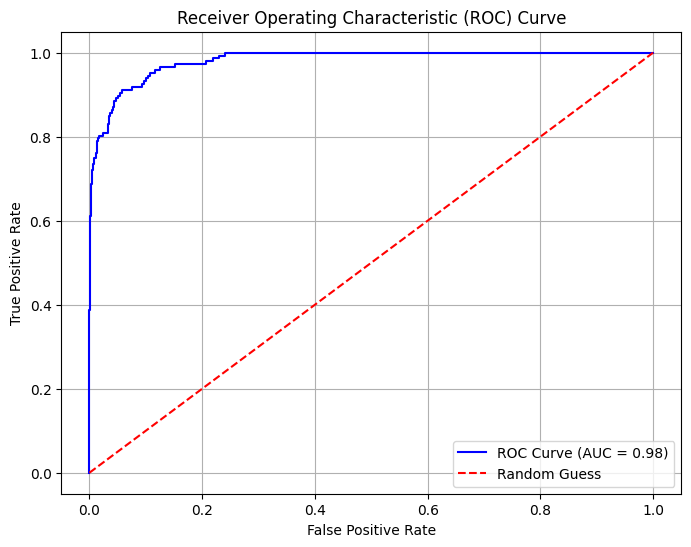

ROC 曲線已繪製並儲存為 roc_curve_v13.png


In [397]:
# 預測機率
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve


print("開始預測...")
model = joblib.load('./lgbm_stock_model_v13.pkl')
y_pred_proba = model.predict_proba(X_test)[:, 1]  # 正類機率 (二分類)

# 閾值優化
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # 計算F1分數
optimal_idx = np.argmax(f1_scores)  # 找到最佳F1分數的索引
optimal_threshold = thresholds[optimal_idx]  # 對應的最佳閾值
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)  # 使用最佳閾值預測

# 顯示結果
best_f1 = f1_score(y_test, y_pred_optimal)
print(f"最佳閾值: {optimal_threshold:.4f}")
print(f"最佳 F1 分數: {best_f1:.4f}")
print("\n最佳分類報告:")
print(classification_report(y_test, y_pred_optimal))
print("最佳閾值下混淆矩陣:\n", confusion_matrix(y_test, y_pred_optimal))

# 儲存最佳閾值
with open('./best_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))
print(f"最佳閾值已儲存至 './best_threshold.txt'")

# 繪製 ROC 曲線（作為最終評估）
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.savefig('roc_curve_v13.png')
plt.show()
print("ROC 曲線已繪製並儲存為 roc_curve_v13.png")

# 清理記憶體 為了方便重新執行，暫時註解
# del X_test, y_test, y_pred_proba, thresholds, best_y_pred
# gc.collect()

In [398]:
# # 載入模型
# model = joblib.load('./lgbm_stock_model_v13.pkl')
# print("模型已載入")

# # 載入驗證集
# val_ddf = dd.read_csv(val_file, sample=1048576, blocksize='64MB')

# # 獲取模型實際使用的特徵名稱
# model_features = model.booster_.feature_name()  # LGBMClassifier 的特徵名稱從 booster_ 獲取

# # 只保留模型內有的特徵，並移除 'ID'
# available_features = [col for col in model_features if col in val_ddf.columns]
# X_val_ddf = val_ddf[available_features].repartition(npartitions=5)  # 減少分區數

# # 數據清洗並轉為 Pandas DataFrame
# print("清洗驗證集數據並轉換格式...")
# X_val = X_val_ddf.fillna(X_val_ddf.mean()).replace([np.inf, -np.inf], np.nan).fillna(X_val_ddf.max().max()).compute()
# print("X_val 形狀:", X_val.shape)

# # 載入最佳閾值
# with open('./best_threshold.txt', 'r') as f:
#     best_threshold = float(f.read())
# print(f"使用的最佳閾值: {best_threshold}")

# # 預測
# print("開始預測驗證集...")
# y_pred_proba_val = model.predict_proba(X_val)[:, 1]  # 正類機率
# y_pred_val = (y_pred_proba_val >= best_threshold).astype(int)

# # 獲取 ID 並生成提交文件
# val_id = val_ddf['ID'].compute()
# submission_df = pd.DataFrame({'ID': val_id, '飆股': y_pred_val})
# submission_df.to_csv('./submission.csv', index=False)
# print("預測結果已儲存至 ./submission.csv")

# # 清理記憶體 為了方便重新執行，暫時註解
# # del val_ddf, X_val_ddf, X_val, y_pred_proba_val, y_pred_val, val_id, submission_df, model
# # gc.collect()